Text MIning on IMDB dataset

In [0]:
#Download IMDB dataset
import tensorflow as tf
#tf.enable_eager_execution()

import os
import sys
import tarfile
import time
import urllib.request

source = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
target = 'aclImdb_v1.tar.gz'

urllib.request.urlretrieve(source, target)

('aclImdb_v1.tar.gz', <http.client.HTTPMessage at 0x7fd55523a4a8>)

Extract the file

In [0]:
import tarfile
with tarfile.open('aclImdb_v1.tar.gz', 'r:gz') as tar:
  tar.extractall()

Read the file

In [0]:
!pip install pyprind
import pyprind
import pandas as pd
import os

# change the `basepath` to the directory of the
# unzipped movie dataset

basepath = 'aclImdb'

labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in sorted(os.listdir(path)):
            with open(os.path.join(path, file), 
                      'r', encoding='utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], 
                           ignore_index=True)
            pbar.update()
df.columns = ['review', 'sentiment']

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:20


In [0]:
import numpy as np
#Shuffling the DataFrame:
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

In [0]:
#Saving the assembled data as CSV file:
df.to_csv('movie_data.csv', index=False, encoding='utf-8')

In [0]:
import pandas as pd

df = pd.read_csv('movie_data.csv', encoding='utf-8')
print( df.shape)
df.head()

(50000, 2)


,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [0]:
#remove all of the HTML markup

import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

df['review'] = df['review'].apply(preprocessor)

In [0]:
#Create the X(Predictor) and y target variable

X = df['review'].values
y = df['sentiment'].values

#Splitting the set into training and testing in the ratio 50:50
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, 
                                                    stratify=y,
                                                    random_state = 1)

In [0]:
#Word stemming: Find the root words

from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [0]:
#stop-word removal
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# Use a GridSearchCV object to find the optimal set of parameters for our
# logistic regression model using 5-fold stratified cross-validation

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

#TFIDF, short for term frequency–inverse document frequency. Down weight the term frequency by relevance.
tfidf = TfidfVectorizer(strip_accents=None,   
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0, solver='liblinear'))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=False,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [0]:
#Print out the best parameter combination and the best cross validation scores
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x7ff16012d488>} 
CV Accuracy: 0.896


In [0]:
#Use the best estimators: We achieved about 90% accuracy
clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Test Accuracy: 0.897


In [0]:
# Lets run the prediction for a few records
print(X_test[1:10,])
print(clf.predict(X_test[1:10,]))
print(y_test[1:10,])

['i just wanted to say that i love gheorghe muresan so i automatically loved this movie everything else about it was so so billy crystal is a good actor even if he is annoying but the thing that made this movie was at least for a basketball fan seeing gheorghe muresan act '
 ' antwone fisher tells of a young black u s navy enlisted man and product of childhood abuse and neglect luke whose hostility toward others gets him a stint with the base shrink washington leading to introspection self appraisal and a return to his roots pat sanitized and sentimental antwone fisher is a solid feel good flick about the reconciliation of past regrets and closure good old hollywood style entertainment family values entertainment with just a hint of corn b '
 'this is an excellent film dealing with a potentially exploitative subject with great sensitivity anne reid previously best known in the uk for her tv roles including dinnerladies a victoria wood scripted series on in company catering workers if y

**LDA: Topic modeling with Latent Dirichlet Allocation**

In [0]:
#Load dataset
import pandas as pd

df = pd.read_csv('movie_data.csv', encoding='utf-8')

df.head(3)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0


In [0]:
# use the CountVectorizer to create the bag-ofwords
# matrix as input to the LDA
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english',
                        max_df=.1,   #we set the maximum document frequency of words to be considered to 10 percent (max_df=.1)
                                     # to exclude words that occur too frequently across documents.                        
                        max_features=5000)  #we limited the number of words to be considered 
                                            #to the most frequently occurring 5,000 words
X = count.fit_transform(df['review'].values)
X

<50000x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 2780504 stored elements in Compressed Sparse Row format>

In [0]:
# Fit a LatentDirichletAllocation
# estimator to the bag-of-words matrix and infer the 10 different topics from the
# documents(take 10 mints to run the whole dataset)

from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10,
                                random_state=123)

X_topics = lda.fit_transform(X)

In [0]:
# To analyze the results, let's print the five most important words for each of the
# 10 topics. Note that the word importance values are ranked in increasing order.
# Thus, to print the top five words, we need to sort the topic array in reverse order

n_top_words = 5
feature_names = count.get_feature_names()

for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
                    for i in topic.argsort()\
                        [:-n_top_words - 1:-1]]))

Topic 1:
worst minutes awful script stupid
Topic 2:
family mother father children girl
Topic 3:
american war dvd music tv
Topic 4:
human audience cinema art sense
Topic 5:
police guy car dead murder
Topic 6:
horror house sex girl woman
Topic 7:
role performance comedy actor performances
Topic 8:
series episode war episodes tv
Topic 9:
book version original read novel
Topic 10:
action fight guy guys cool


**Sentiment Analysis**

In [0]:
import tensorflow as tf

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow_datasets as tfds
import tensorflow as tf

In [0]:
# Get the data(Will take about 3 mints)
# Use the version pre-encoded with an ~8k vocabulary.  # Also return the `info` structure. 
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
# Return (example, label) pairs from the dataset (instead of a dictionary).
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteBPCFY2/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteBPCFY2/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteBPCFY2/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


Try Encoder

In [0]:
tokenizer = info.features['text'].encoder
print ('Vocabulary size: {}'.format(tokenizer.vocab_size))

Vocabulary size: 8185


In [0]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_dataset))



In [0]:
for example_batch, label_batch in train_dataset.take(2):
  print("Batch shape:", example_batch.shape)
  print("label shape:", label_batch.shape)
  

Batch shape: (64, 1615)
label shape: (64,)
Batch shape: (64, 1048)
label shape: (64,)


Model

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          261920    
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 268,737
Trainable params: 268,737
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

NUM_EPOCHS = 10

history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset, validation_steps=39,steps_per_epoch=39)  

Epoch 1/10
39/39 [==============================] - 50s 1s/step - loss: 0.2454 - accuracy: 0.9123 - val_loss: 0.4041 - val_accuracy: 0.8385
Epoch 2/10
39/39 [==============================] - 43s 1s/step - loss: 0.2303 - accuracy: 0.9219 - val_loss: 0.3835 - val_accuracy: 0.8554
Epoch 3/10
39/39 [==============================] - 47s 1s/step - loss: 0.2273 - accuracy: 0.9199 - val_loss: 0.3798 - val_accuracy: 0.8498
Epoch 4/10
39/39 [==============================] - 45s 1s/step - loss: 0.2292 - accuracy: 0.9123 - val_loss: 0.3935 - val_accuracy: 0.8405
Epoch 5/10
39/39 [==============================] - 46s 1s/step - loss: 0.2063 - accuracy: 0.9295 - val_loss: 0.3931 - val_accuracy: 0.8526
Epoch 6/10
39/39 [==============================] - 47s 1s/step - loss: 0.1903 - accuracy: 0.9347 - val_loss: 0.3839 - val_accuracy: 0.8518
Epoch 7/10
39/39 [==============================] - 45s 1s/step - loss: 0.2244 - accuracy: 0.9159 - val_loss: 0.3971 - val_accuracy: 0.8494
Epoch 8/10
39/39 [==

LSTM Model using Warren Buffett's 2015-2019 annual letters to shareholders 

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [0]:
tokenizer = Tokenizer()

data = open('2015-2019.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
# example:[[I, am], [I, am, Joe], [I, am, Joe, Zhou]] -> [[1,2],[1,2,85],[1,2,85,5]]
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
# example:[[1,2],[1,2,85],[1,2,85,5]] ->[[0,0,1,2],[0,1,2,85],[1,2,85,5]]
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))#"pre means put 0 at the front instead of at the end"

# create predictors and label
# example: [1,2,85,5]:[1,2,85],[5]

predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [0]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dropout(0.2))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 29, 100)           302700    
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               301200    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 3027)              911127    
Total params: 1,515,027
Trainable params: 1,515,027
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
 history = model.fit(predictors, label, epochs=50, verbose=1)

Epoch 1/50
482/482 [==============================] - 45s 94ms/step - loss: 6.3388 - accuracy: 0.0483
Epoch 2/50
482/482 [==============================] - 45s 94ms/step - loss: 5.9853 - accuracy: 0.0623
Epoch 3/50
482/482 [==============================] - 45s 94ms/step - loss: 5.6519 - accuracy: 0.0749
Epoch 4/50
482/482 [==============================] - 46s 95ms/step - loss: 5.3157 - accuracy: 0.0923
Epoch 5/50
482/482 [==============================] - 46s 95ms/step - loss: 4.9583 - accuracy: 0.1184
Epoch 6/50
482/482 [==============================] - 46s 94ms/step - loss: 4.6031 - accuracy: 0.1475
Epoch 7/50
482/482 [==============================] - 45s 94ms/step - loss: 4.2691 - accuracy: 0.1839
Epoch 8/50
482/482 [==============================] - 46s 95ms/step - loss: 3.9526 - accuracy: 0.2248
Epoch 9/50
482/482 [==============================] - 46s 95ms/step - loss: 3.6416 - accuracy: 0.2691
Epoch 10/50
482/482 [==============================] - 45s 94ms/step - loss: 3.348

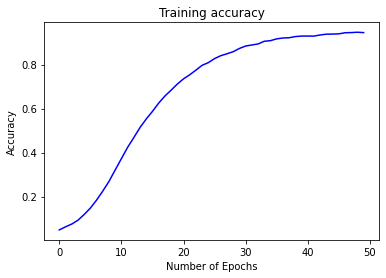

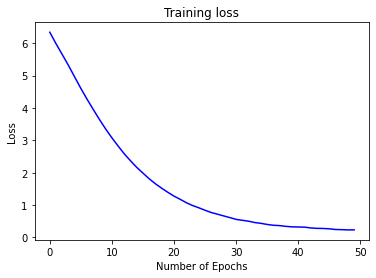

In [0]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b')
plt.title('Training accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')


plt.figure()
plt.plot(epochs, loss, 'b')
plt.title('Training loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

plt.show()

In [0]:
seed_text = "This is my favorate stock, and it is a great company. In 2020 We should invest in"
next_words = 50
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

This is my favorate stock, and it is a great company. In 2020 We should invest in the years that we need at opposite times for the boss to cheat a little worth to the total of the meantime was rapidly growth to receive was a long time investment 1942 was a book of a director of portland gas light in the years following if the left
